## **NO2 Concentration Forecast** : Deep Learning

In [ ]:
import pandas as pd
import plotly.express as px
from meteostat import Hourly, Stations
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib

In [2]:
measurement_data = pd.read_csv('data/raw/measurement_data.csv')
measurement_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621588 entries, 0 to 621587
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Measurement date  621588 non-null  object 
 1   Station code      621588 non-null  int64  
 2   Latitude          621588 non-null  float64
 3   Longitude         621588 non-null  float64
 4   SO2               621588 non-null  float64
 5   NO2               621588 non-null  float64
 6   O3                621588 non-null  float64
 7   CO                621588 non-null  float64
 8   PM10              621588 non-null  float64
 9   PM2.5             621588 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 47.4+ MB


In [3]:
instrument_data = pd.read_csv('data/raw/instrument_data.csv')
instrument_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3703662 entries, 0 to 3703661
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Measurement date   object 
 1   Station code       int64  
 2   Item code          int64  
 3   Average value      float64
 4   Instrument status  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 141.3+ MB


In [4]:
measurement_data['Measurement date'] = pd.to_datetime(measurement_data['Measurement date'])
instrument_data['Measurement date'] = pd.to_datetime(instrument_data['Measurement date'])

In [5]:
measurement_data.head()

,Measurement date,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2021-01-01 00:00:00,204,37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2021-01-01 01:00:00,204,37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2021-01-01 02:00:00,204,37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2021-01-01 03:00:00,204,37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2021-01-01 04:00:00,204,37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


### **Data Preprocessing**

##### (A) Historical Label Data

In [6]:
S211_data = measurement_data[measurement_data['Station code']==211].reset_index()[['Measurement date', 'NO2']]
S211_data.head()

,Measurement date,NO2
0,2021-01-01 00:00:00,0.045
1,2021-01-01 01:00:00,0.045
2,2021-01-01 02:00:00,0.043
3,2021-01-01 03:00:00,0.039
4,2021-01-01 04:00:00,0.038


In [7]:
S211_data.describe()

,Measurement date,NO2
count,22316,22316.000000
mean,2022-04-12 09:49:46.502957568,0.027112
min,2021-01-01 00:00:00,-1.000000
25%,2021-08-21 10:45:00,0.016000
50%,2022-04-10 21:30:00,0.025000
75%,2022-11-29 08:15:00,0.039000
max,2023-07-31 23:00:00,0.135000
std,NaN,0.042084


In [8]:
px.line(data_frame=S211_data, x='Measurement date', y ='NO2')

In [9]:
no2_mean = round(S211_data[S211_data['NO2']>0]['NO2'].mean(), 4)
no2_mean

np.float64(0.0289)

In [10]:
S211_data['NO2'] = S211_data['NO2'].apply(lambda x: no2_mean if x<0 else x)

In [11]:
px.box(S211_data['NO2'])

In [12]:
px.line(data_frame=S211_data, x='Measurement date', y ='NO2')

In [ ]:
S211_data['hour'] = S211_data['Measurement date'].dt.hour
S211_data['dayofweek'] = S211_data['Measurement date'].dt.dayofweek
S211_data['month'] = S211_data['Measurement date'].dt.month
S211_data['season'] = S211_data['Measurement date'].dt.month % 12 // 3 + 1  # Winter=1, Spring=2, Summer=3, Autumn=4
S211_data['is_weekend'] = S211_data['dayofweek'].isin([5, 6]).astype(int)

In [14]:
S211_data.head()

,Measurement date,NO2,hour,dayofweek,month,season,is_weekend
0,2021-01-01 00:00:00,0.045,0,4,1,1,0
1,2021-01-01 01:00:00,0.045,1,4,1,1,0
2,2021-01-01 02:00:00,0.043,2,4,1,1,0
3,2021-01-01 03:00:00,0.039,3,4,1,1,0
4,2021-01-01 04:00:00,0.038,4,4,1,1,0


##### (B) Weather Data

In [ ]:
start = datetime(2021, 1, 1)
end = datetime(2023, 12, 31)

#finding the nearest weather station
stations = Stations()
stations = stations.nearby(37.572016, 127.005008)  # Madrid coords (example)
station = stations.fetch(1)

#getting the hourly data
data = Hourly(station.index[0], start, end)
weather = data.fetch()


In [16]:
weather

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2021-01-01 00:00:00,-8.5,-12.5,73.0,NaN,NaN,30.0,9.0,NaN,1027.4,NaN,2.0
2021-01-01 01:00:00,-6.3,-13.0,59.0,NaN,NaN,11.0,7.4,NaN,1026.9,NaN,2.0
2021-01-01 02:00:00,-4.6,-12.5,54.0,NaN,NaN,291.0,9.3,NaN,1026.5,NaN,2.0
2021-01-01 03:00:00,-1.0,-9.6,52.0,NaN,NaN,207.0,7.6,NaN,1025.7,NaN,2.0
2021-01-01 04:00:00,-2.2,-10.7,52.0,NaN,NaN,291.0,11.1,NaN,1025.5,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,2.4,2.3,99.0,0.0,NaN,50.0,5.4,NaN,1009.1,NaN,8.0
2023-12-30 21:00:00,2.4,2.3,99.0,0.2,NaN,50.0,5.4,NaN,1009.0,NaN,7.0
2023-12-30 22:00:00,2.8,2.7,99.0,0.3,NaN,340.0,7.6,NaN,1009.8,NaN,7.0


In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26257 entries, 2021-01-01 00:00:00 to 2023-12-31 00:00:00
Freq: h
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    26257 non-null  float64
 1   dwpt    26257 non-null  float64
 2   rhum    26257 non-null  float64
 3   prcp    14026 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    26257 non-null  float64
 6   wspd    26257 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    26257 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    26008 non-null  float64
dtypes: float64(11)
memory usage: 2.4 MB


In [18]:
weather.dropna(how='any', axis=1, inplace=True)

In [19]:
weather = weather.reset_index()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26257 entries, 0 to 26256
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    26257 non-null  datetime64[ns]
 1   temp    26257 non-null  float64       
 2   dwpt    26257 non-null  float64       
 3   rhum    26257 non-null  float64       
 4   wdir    26257 non-null  float64       
 5   wspd    26257 non-null  float64       
 6   pres    26257 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.4 MB


In [20]:
weather.head()

,time,temp,dwpt,rhum,wdir,wspd,pres
0,2021-01-01 00:00:00,-8.5,-12.5,73.0,30.0,9.0,1027.4
1,2021-01-01 01:00:00,-6.3,-13.0,59.0,11.0,7.4,1026.9
2,2021-01-01 02:00:00,-4.6,-12.5,54.0,291.0,9.3,1026.5
3,2021-01-01 03:00:00,-1.0,-9.6,52.0,207.0,7.6,1025.7
4,2021-01-01 04:00:00,-2.2,-10.7,52.0,291.0,11.1,1025.5


##### (C) Consolidated Data

In [21]:
final_data = pd.merge(S211_data, weather, how='inner', left_on='Measurement date', right_on='time')

In [22]:
final_data.drop(columns=['time'], inplace=True)
final_data.head()

,Measurement date,NO2,hour,dayofweek,month,season,is_weekend,temp,dwpt,rhum,wdir,wspd,pres
0,2021-01-01 00:00:00,0.045,0,4,1,1,0,-8.5,-12.5,73.0,30.0,9.0,1027.4
1,2021-01-01 01:00:00,0.045,1,4,1,1,0,-6.3,-13.0,59.0,11.0,7.4,1026.9
2,2021-01-01 02:00:00,0.043,2,4,1,1,0,-4.6,-12.5,54.0,291.0,9.3,1026.5
3,2021-01-01 03:00:00,0.039,3,4,1,1,0,-1.0,-9.6,52.0,207.0,7.6,1025.7
4,2021-01-01 04:00:00,0.038,4,4,1,1,0,-2.2,-10.7,52.0,291.0,11.1,1025.5


In [23]:
final_data.corr()

,Measurement date,NO2,hour,dayofweek,month,season,is_weekend,temp,dwpt,rhum,wdir,wspd,pres
Measurement date,1.000000,-0.111983,0.000979,0.002227,0.125013,0.078356,0.003905,0.104187,0.119995,0.091751,0.023997,-0.141257,-0.086214
NO2,-0.111983,1.000000,0.051226,-0.013059,-0.161275,-0.272092,0.026829,-0.374963,-0.387106,-0.160088,0.022132,0.063151,0.306240
hour,0.000979,0.051226,1.000000,0.001291,-0.000107,-0.000048,0.000893,-0.167778,-0.006518,0.352179,-0.104172,-0.259278,0.022369
dayofweek,0.002227,-0.013059,0.001291,1.000000,-0.001025,-0.004653,0.791387,0.014201,0.010869,-0.004496,-0.016429,-0.027641,-0.007698
month,0.125013,-0.161275,-0.000107,-0.001025,1.000000,0.629920,-0.008683,0.286230,0.335170,0.222597,-0.082662,-0.143602,-0.132915
season,0.078356,-0.272092,-0.000048,-0.004653,0.629920,1.000000,-0.004947,0.634037,0.657256,0.295047,-0.142172,-0.127810,-0.408773
is_weekend,0.003905,0.026829,0.000893,0.791387,-0.008683,-0.004947,1.000000,0.007636,0.010164,0.009870,-0.023175,-0.016866,-0.002681
temp,0.104187,-0.374963,-0.167778,0.014201,0.286230,0.634037,0.007636,1.000000,0.923690,0.194811,-0.124385,-0.035771,-0.762953
dwpt,0.119995,-0.387106,-0.006518,0.010869,0.335170,0.657256,0.010164,0.923690,1.000000,0.549500,-0.177157,-0.140975,-0.798079
rhum,0.091751,-0.160088,0.352179,-0.004496,0.222597,0.295047,0.009870,0.194811,0.549500,1.000000,-0.190017,-0.275606,-0.395711


In [24]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22316 entries, 0 to 22315
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Measurement date  22316 non-null  datetime64[ns]
 1   NO2               22316 non-null  float64       
 2   hour              22316 non-null  int32         
 3   dayofweek         22316 non-null  int32         
 4   month             22316 non-null  int32         
 5   season            22316 non-null  int32         
 6   is_weekend        22316 non-null  int64         
 7   temp              22316 non-null  float64       
 8   dwpt              22316 non-null  float64       
 9   rhum              22316 non-null  float64       
 10  wdir              22316 non-null  float64       
 11  wspd              22316 non-null  float64       
 12  pres              22316 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int32(4), int64(1)
memory usage: 1.9 MB


### **Feature Engineering**

In [26]:
final_data = final_data.set_index('Measurement date')

In [27]:
final_data['hour_sin'] = np.sin(2 * np.pi * final_data.index.hour / 24)
final_data['hour_cos'] = np.cos(2 * np.pi * final_data.index.hour / 24)
final_data['day_sin'] = np.sin(2 * np.pi * final_data.index.dayofweek / 7)
final_data['day_cos'] = np.cos(2 * np.pi * final_data.index.dayofweek / 7)
final_data['month_sin'] = np.sin(2 * np.pi * final_data.index.month / 12)
final_data['month_cos'] = np.cos(2 * np.pi * final_data.index.month / 12)

### **Feature Selection**

In [28]:
X = final_data.drop(columns=['NO2'])  
y = final_data['NO2']                 

In [29]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest (you can use XGBRegressor too)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestRegressor(random_state=42)

In [30]:
importances = model.feature_importances_
feature_names = X.columns

feature_scores = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_scores)

dwpt          0.245682
pres          0.151619
temp          0.091145
wdir          0.082546
rhum          0.079310
wspd          0.069929
hour          0.049434
day_sin       0.039907
dayofweek     0.029755
day_cos       0.027766
hour_cos      0.026335
month         0.023096
month_cos     0.021370
month_sin     0.021343
hour_sin      0.021045
season        0.015035
is_weekend    0.004683
dtype: float64


In [31]:
feature_cols = ['hour', 'dayofweek', 'month', 'season', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'NO2']

In [32]:
final_data.drop(columns=['month_cos', 'is_weekend'], inplace=True)

### **Model Training**

In [33]:
split_idx = int(len(final_data) * 0.8)
df_train = final_data.iloc[:split_idx].copy()
df_test = final_data.iloc[split_idx:].copy()

In [34]:
scaler = MinMaxScaler()
scaler.fit(df_train[feature_cols])
df_train[feature_cols] = scaler.transform(df_train[feature_cols])
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

In [35]:
df_train.head()

,NO2,hour,dayofweek,month,season,temp,dwpt,rhum,wdir,wspd,pres,hour_sin,hour_cos,day_sin,day_cos,month_sin
Measurement date,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.333333,0.000000,0.666667,0.0,0.0,0.180657,0.291367,0.674699,0.083333,0.220588,0.774775,0.500000,1.000000,0.277479,0.0,0.75
2021-01-01 01:00:00,0.333333,0.043478,0.666667,0.0,0.0,0.220803,0.282374,0.506024,0.030556,0.181373,0.763514,0.629410,0.982963,0.277479,0.0,0.75
2021-01-01 02:00:00,0.318519,0.086957,0.666667,0.0,0.0,0.251825,0.291367,0.445783,0.808333,0.227941,0.754505,0.750000,0.933013,0.277479,0.0,0.75
2021-01-01 03:00:00,0.288889,0.130435,0.666667,0.0,0.0,0.317518,0.343525,0.421687,0.575000,0.186275,0.736486,0.853553,0.853553,0.277479,0.0,0.75
2021-01-01 04:00:00,0.281481,0.173913,0.666667,0.0,0.0,0.295620,0.323741,0.421687,0.808333,0.272059,0.731982,0.933013,0.750000,0.277479,0.0,0.75


In [ ]:
#function to create matrix examples for training
def create_sequences(data, target_col='SO2', window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i][data.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

In [37]:
X_train, y_train = create_sequences(df_train, target_col='NO2', window_size=72)
X_test, y_test = create_sequences(df_test, target_col='NO2', window_size=72)

In [38]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop])

Epoch 1/30


501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0193 - val_loss: 0.0025
Epoch 2/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 3/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/ste

In [39]:
y_pred = model.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
R2: 0.8909665344963217


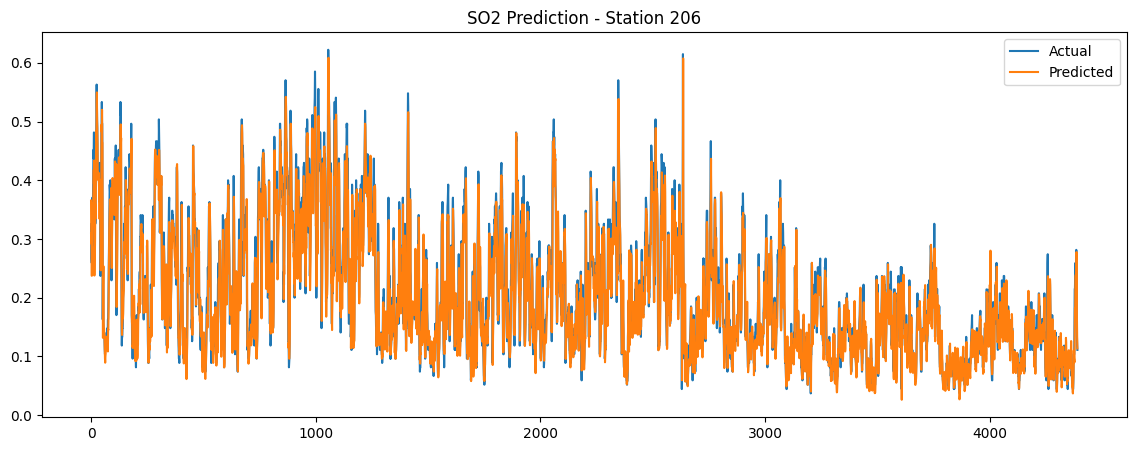

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f'NO2 Prediction - Station 206')
plt.legend()
plt.show()

### **Predicting for August 2023**

In [41]:
aug_weather_data = weather[(weather['time'].dt.month==8) & (weather['time'].dt.year==2023)]
aug_weather_data.describe()

,time,temp,dwpt,rhum,wdir,wspd,pres
count,744,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,2023-08-16 11:29:59.999999744,27.127419,22.335618,76.259409,167.461022,7.734274,1004.750806
min,2023-08-01 00:00:00,19.700000,17.600000,49.000000,0.000000,0.000000,991.700000
25%,2023-08-08 17:45:00,24.500000,21.300000,66.000000,54.000000,5.000000,1002.900000
50%,2023-08-16 11:30:00,27.050000,22.400000,77.000000,173.500000,7.600000,1004.900000
75%,2023-08-24 05:15:00,29.600000,23.400000,87.000000,271.000000,10.100000,1007.925000
max,2023-08-31 23:00:00,35.700000,26.700000,99.000000,360.000000,27.400000,1012.200000
std,NaN,3.439412,1.514366,12.052204,109.151597,3.686864,3.891745


In [ ]:
import numpy as np
import pandas as pd
import json

n_steps = 744
WINDOW_SIZE = 72

#creating relevant features in testing data
aug_weather_data['NO2'] = np.nan

aug_weather_data['hour'] = aug_weather_data['time'].dt.hour
aug_weather_data['dayofweek'] = aug_weather_data['time'].dt.dayofweek
aug_weather_data['month'] = aug_weather_data['time'].dt.month
aug_weather_data['season'] = aug_weather_data['time'].dt.month % 12 // 3 + 1 

aug_weather_data.set_index('time', inplace=True)
aug_weather_data['hour_sin'] = np.sin(2 * np.pi * aug_weather_data.index.hour / 24)
aug_weather_data['hour_cos'] = np.cos(2 * np.pi * aug_weather_data.index.hour / 24)
aug_weather_data['day_sin'] = np.sin(2 * np.pi * aug_weather_data.index.dayofweek / 7)
aug_weather_data['day_cos'] = np.cos(2 * np.pi * aug_weather_data.index.dayofweek / 7)
aug_weather_data['month_sin'] = np.sin(2 * np.pi * aug_weather_data.index.month / 12)
aug_weather_data['month_cos'] = np.cos(2 * np.pi * aug_weather_data.index.month / 12)


aug_weather_data = aug_weather_data[feature_cols] 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
#scaling future weather data
scaled_future = scaler.transform(aug_weather_data)
future_weather_df_scaled = pd.DataFrame(scaled_future, columns=feature_cols, index=aug_weather_data.index)

#initializing the input window with the last known scaled data
last_known_window = df_test[feature_cols].iloc[-WINDOW_SIZE:].copy()
current_input = last_known_window.values.reshape(1, WINDOW_SIZE, len(feature_cols))

In [ ]:
#recursive forecasting
future_no2_scaled = []

for step in range(n_steps):

    pred = model.predict(current_input)[0, 0]
    future_no2_scaled.append(pred)
    
    #preparing next input row using weather data at time t
    next_row = future_weather_df_scaled.iloc[step].copy()
    next_row['NO2'] = pred  

    #moving input window forward for the next forecast
    new_input = current_input[0, 1:, :].tolist()  
    new_input.append(next_row.values.tolist())    
    current_input = np.array(new_input).reshape(1, WINDOW_SIZE, len(feature_cols))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
#inverse transformation of predictions
dummy = np.zeros((len(future_no2_scaled), len(feature_cols)))
dummy[:, feature_cols.index('NO2')] = future_no2_scaled
no2_unscaled = scaler.inverse_transform(dummy)[:, feature_cols.index('NO2')]
no2_unscaled = np.clip(no2_unscaled, min=0)

#rendering the output in JSON format
forecast_times = future_weather_df_scaled.index[:n_steps]
forecast_dict = {str(ts): round(float(val), 3) for ts, val in zip(forecast_times, no2_unscaled)}

with open(f'station_211_forecast.json', 'w') as f:
   json.dump(forecast_dict, f, indent=2)

print(f"✅ Forecast saved for next month → station_211_forecast.json")


✅ Forecast saved for next month → station_211_forecast.json


In [48]:
forecast_dict

{'2023-08-01 00:00:00': 0.116,
 '2023-08-01 01:00:00': 0.0,
 '2023-08-01 02:00:00': 0.01,
 '2023-08-01 03:00:00': 0.02,
 '2023-08-01 04:00:00': 0.026,
 '2023-08-01 05:00:00': 0.031,
 '2023-08-01 06:00:00': 0.037,
 '2023-08-01 07:00:00': 0.042,
 '2023-08-01 08:00:00': 0.047,
 '2023-08-01 09:00:00': 0.052,
 '2023-08-01 10:00:00': 0.057,
 '2023-08-01 11:00:00': 0.062,
 '2023-08-01 12:00:00': 0.067,
 '2023-08-01 13:00:00': 0.071,
 '2023-08-01 14:00:00': 0.075,
 '2023-08-01 15:00:00': 0.079,
 '2023-08-01 16:00:00': 0.084,
 '2023-08-01 17:00:00': 0.088,
 '2023-08-01 18:00:00': 0.092,
 '2023-08-01 19:00:00': 0.096,
 '2023-08-01 20:00:00': 0.1,
 '2023-08-01 21:00:00': 0.105,
 '2023-08-01 22:00:00': 0.109,
 '2023-08-01 23:00:00': 0.114,
 '2023-08-02 00:00:00': 0.119,
 '2023-08-02 01:00:00': 0.0,
 '2023-08-02 02:00:00': 0.013,
 '2023-08-02 03:00:00': 0.019,
 '2023-08-02 04:00:00': 0.025,
 '2023-08-02 05:00:00': 0.03,
 '2023-08-02 06:00:00': 0.035,
 '2023-08-02 07:00:00': 0.04,
 '2023-08-02 08:00